# ***Exploratory Data Analysis***

---

## ***HLF Network***


In [581]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# uyarilari dikkate alma
import warnings
warnings.filterwarnings('ignore')

sns.set_style('white')

# pandas varsayilan olarak cok sayida sutun veya satir varsa tumunu gostermez
# bu nedenle 100 sutun ve satir gostermesi icin
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# virgulden sonra belirli sayida basamak gosterimi icin 
pd.options.display.float_format = '{:,.3f}'.format
# sutunun genisligi
pd.options.display.max_colwidth = 100

# font tanimlamalari
title_font = {'family': 'times new roman', 'color': 'black', 
              'weight': 'normal', 'size': 16}
axis_font  = {'family': 'times new roman', 'color': 'black', 
              'weight': 'normal', 'size': 16}
#custom color codes
mycolors = ['#CB4335','#3498DB', '#A2D9CE', 
            '#E74C3C', '#5499C7', '#73C6B6', 
            '#C39BD3', '#E59866', '#16A085']
my_palette = sns.color_palette(mycolors)

plt.rcParams["font.family"] = "times new roman"
plt.rcParams["font.size"] = "14"

In [569]:
def preprop_data(directory, test_type):
    # veri setini dataframe icerisine yukle
    hlf = pd.DataFrame([])
    test_duration=300
    for user in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]:
        df = pd.read_csv(test_type+'/'+directory+'/'+str(user)+'_users_'+test_type+'_stats.csv')
        df['users'] = user
        df['duration'] = test_duration
        df.drop(index=1, inplace=True)
        hlf = pd.concat([hlf, df])
        
    hlf.drop(hlf.columns[range(11,23)], axis=1, inplace=True)
    hlf.drop(columns=['Type'], axis=1, inplace=True)
    # transaction throughput = total committed transactions / total time in secs
    hlf['throughput'] = (hlf['Request Count']-hlf['Failure Count']) / hlf['duration']
    hlf['failure_ratio'] = hlf['Failure Count'] / hlf['Request Count'] * 100
    hlf['success_count'] = hlf['Request Count'] - hlf['Failure Count']
    hlf['success_ratio'] = hlf['success_count'] / hlf['Request Count'] * 100
    
    return hlf

In [570]:
def plot_latency(hlf, directory, test_type):
    plt.figure(figsize=(15,8), dpi=100)
    _ = sns.barplot(x= hlf['users'],y=hlf['Average Response Time']/1000, color=mycolors[1])
    plt.ylabel('Average Response Time (s)', fontdict=axis_font)
    plt.xlabel('# of Users', fontdict=axis_font)
    plt.xticks(fontsize=10, fontname='times new roman')
    plt.yticks(fontsize=10, fontname='times new roman')
    plt.yscale('log')
    plt.gca().yaxis.grid(True, linestyle='--')
    plt.savefig('./images/'+test_type+'_'+directory+'_latency.png', 
                bbox_inches='tight')
    plt.show()

In [571]:
def plot_throughput_latency(hlf, directory, test_type):
    c = 0.5
    x = hlf['users']
    fig, ax0 = plt.subplots(1, 1, sharex=True, figsize=(15, 8),dpi=100)
    #fig, ax = plt.subplots()
    lns1 = ax0.scatter(hlf['users'],hlf['throughput'],color=mycolors[0], alpha=0.9, 
                       label='Throughput')
    ax0.plot(hlf['users'],hlf['throughput'], color=mycolors[0], alpha=0.8,label='_nolegend_')
    ax0.set_ylabel('Throughput (request/s)', fontdict=axis_font)
    ax0.set_xlabel('# of Users', fontdict=axis_font)
    #ax0.set_ylim(0,20)
    ax0.set_xscale('log')
    plt.xticks(fontsize=10, fontname='times new roman')
    plt.yticks(fontsize=10, fontname='times new roman')
    plt.gca().yaxis.grid(True, linestyle='--')
    ax1 = ax0.twinx()
    lns2 = ax1.bar(x= hlf['users'],height=hlf['Average Response Time']/1000, color=mycolors[1], 
    width=c*np.array(x), alpha=0.8, label='Average Response Time')
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()
    ax1.set_ylabel('Average Response Time (s)', fontdict=axis_font)
    # added these three lines
    lns = [lns1]+[lns2]
    labs = [l.get_label() for l in lns]
    ax0.legend(lns, labs, loc=2)
    plt.yticks(fontsize=10, fontname='times new roman')
    plt.savefig('./images/'+test_type+'_'+directory+'_throughput_latency.png', bbox_inches='tight')
    plt.show()

In [584]:
def plot_success_failure_latency(hlf, directory, test_type):
    c = 0.5
    x = hlf['users']
    fig, ax0 = plt.subplots(1, 1, sharex=True, figsize=(15, 8),dpi=100)
    #fig, ax = plt.subplots()

    lns1=ax0.scatter(hlf['users'],hlf['Average Response Time']/1000, color=mycolors[0], alpha=0.9,
               label='Average Response Time')
    ax0.plot(hlf['users'],hlf['Average Response Time']/1000, color=mycolors[0], alpha=0.9)


    ax0.set_ylabel('Average Response Time (s)', fontdict=axis_font)
    ax0.set_xlabel('# of Users', fontdict=axis_font)

    ax0.set_xscale('log')
    plt.xticks(fontsize=10, fontname='times new roman')
    plt.yticks(fontsize=10, fontname='times new roman')
    plt.gca().yaxis.grid(True, linestyle='--')

    ax1 = ax0.twinx()
    lns2=ax1.bar(hlf['users'],hlf['success_count'], width=c*np.array(x), 
                 color=mycolors[1], alpha=0.7, label='Successful Requests')
    if hlf['Failure Count'].max()!=0:
        lns3=ax1.bar(hlf['users'],hlf['Failure Count'], bottom=hlf['success_count'], 
                     width=c*np.array(x), color=mycolors[3], alpha=0.7, label='Failed Requests') 
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()
    ax1.set_ylabel('# of Requests', fontdict=axis_font)
    ax1.set_ylim(0,hlf['Request Count'].max()+hlf['Request Count'].max()/50)
    plt.yticks(fontsize=10, fontname='times new roman')
    #ax1.annotate('This is awesome!', xy=(76, 0.75), xycoords='data', textcoords='offset points',arrowprops=dict(arrowstyle="->"))

    # added these three lines
    if hlf['Failure Count'].max()!=0:
        lns = [lns1]+[lns2]+[lns3]
    else:
        lns = [lns1]+[lns2]
    labs = [l.get_label() for l in lns]
    ax0.legend(lns, labs, loc=2)
    plt.savefig('./images/'+test_type+'_'+directory+'_success_failure_latency.png', 
                bbox_inches='tight')
    plt.show()

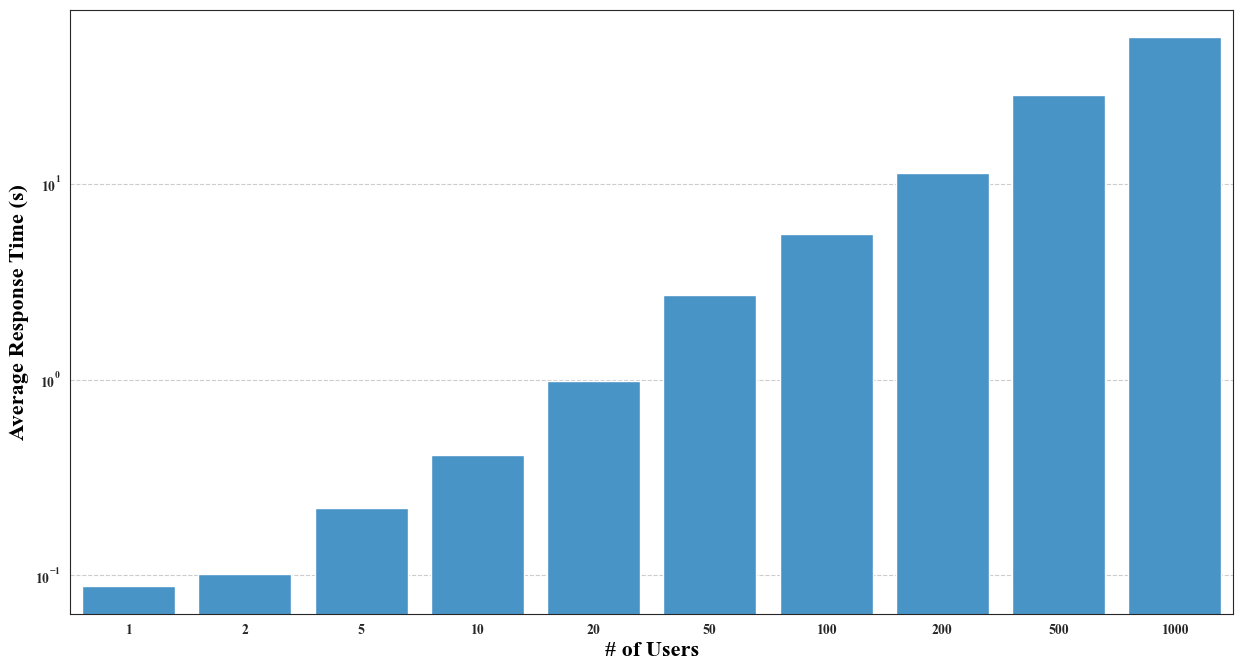

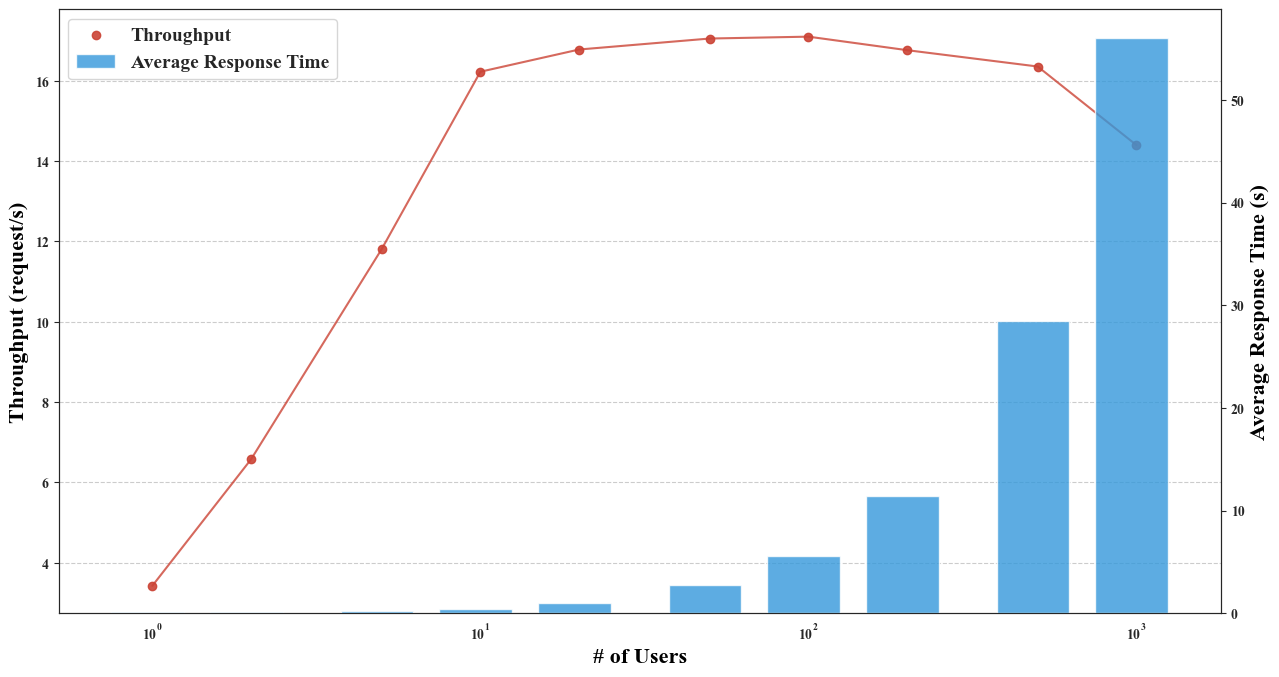

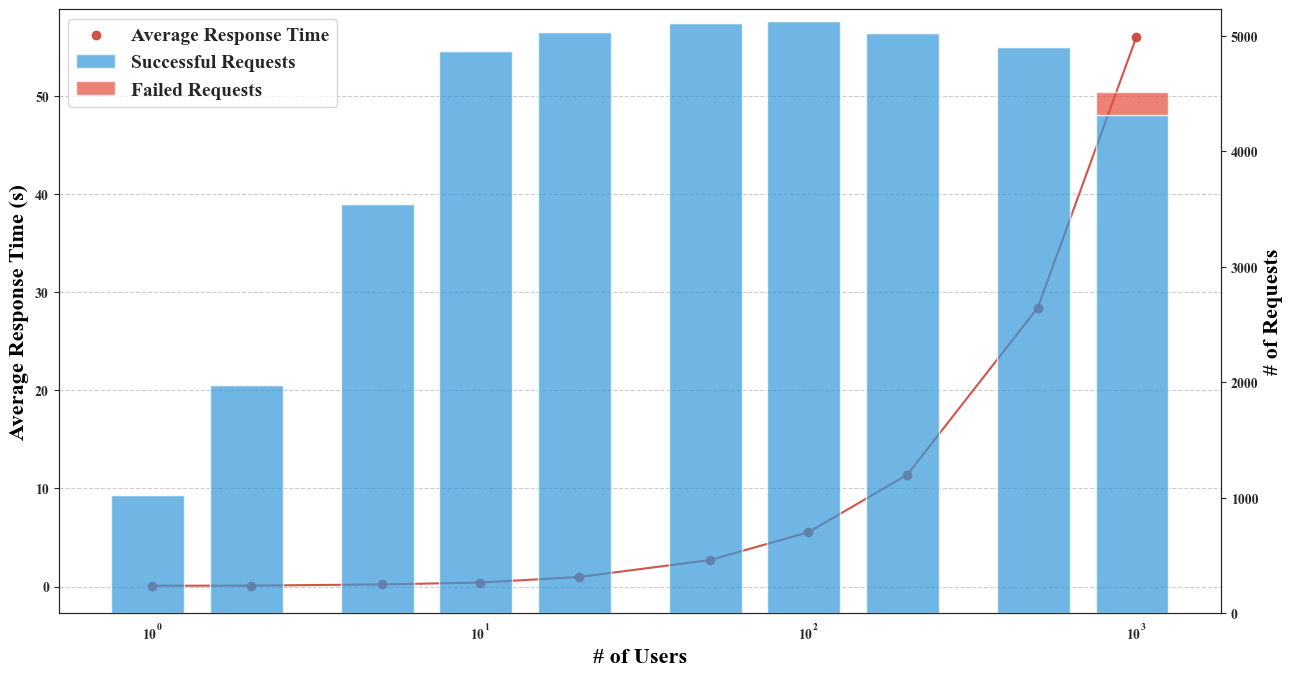

In [586]:
def eda_plot(directory='event_1K', test_type='create'):
    hlf = preprop_data(directory, test_type)
    plot_latency(hlf, directory, test_type)
    plot_throughput_latency(hlf, directory, test_type)
    plot_success_failure_latency(hlf, directory, test_type)
    
eda_plot(directory='event_1K', test_type='create')

In [561]:
# veri setini dataframe icerisine yukle
hlf = pd.DataFrame([])
test_type = 'create'
directory = 'event_1K'
test_duration=300
for user in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]:
    df = pd.read_csv(test_type+'/'+directory+'/'+str(user)+'_users_'+test_type+'_stats.csv')
    df['users'] = user
    df['duration'] = test_duration
    df.drop(index=1, inplace=True)
    hlf = pd.concat([hlf, df])
    

hlf.drop(hlf.columns[range(11,23)], axis=1, inplace=True)

hlf.drop(columns=['Type'], axis=1, inplace=True)

# transaction throughput = total committed transactions / total time in secs
hlf['throughput'] = (hlf['Request Count']-hlf['Failure Count']) / hlf['duration']

hlf['failure_ratio'] = hlf['Failure Count'] / hlf['Request Count'] * 100

hlf['success_count'] = hlf['Request Count'] - hlf['Failure Count']
hlf['success_ratio'] = hlf['success_count'] / hlf['Request Count'] * 100

In [562]:
hlf

,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,Failures/s,users,duration,throughput,failure_ratio,success_count,success_ratio
0,/event/createevent,1028,0,89,88,61,156,15,3.430,0.000,1,300,3.427,0.000,1028,100.000
0,/event/createevent,1973,0,96,102,60,219,15,6.580,0.000,2,300,6.577,0.000,1973,100.000
0,/event/createevent,3542,0,230,220,60,388,15,11.810,0.000,5,300,11.807,0.000,3542,100.000
0,/event/createevent,4867,0,440,414,63,648,15,16.240,0.000,10,300,16.223,0.000,4867,100.000
0,/event/createevent,5033,0,990,980,67,1354,15,16.790,0.000,20,300,16.777,0.000,5033,100.000
0,/event/createevent,5115,0,2700,2702,144,3708,15,17.090,0.000,50,300,17.050,0.000,5115,100.000
0,/event/createevent,5129,0,5600,5541,154,7310,15,17.120,0.000,100,300,17.097,0.000,5129,100.000
0,/event/createevent,5028,0,12000,11397,478,17896,15,16.780,0.000,200,300,16.760,0.000,5028,100.000
0,/event/createevent,4906,0,28000,28418,1453,70832,15,16.390,0.000,500,300,16.353,0.000,4906,100.000
0,/event/createevent,4517,198,57000,56035,445,128957,14,15.070,0.660,1000,300,14.397,4.383,4319,95.617
